In [458]:
## imports
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import statsmodels.tsa.ar_model
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt

In [459]:
## loading and reading in csv dataset using pandas
brazil_df = pd.read_csv('brazil_covid19_new.csv')
brazil_df.head()

,date,region,state,cases,deaths
0,2020-02-26,Sudeste,São Paulo,1,0
1,2020-02-27,Sudeste,São Paulo,1,0
2,2020-02-28,Sudeste,São Paulo,1,0
3,2020-02-29,Sudeste,São Paulo,2,0
4,2020-03-01,Sudeste,São Paulo,2,0


In [460]:
brazil_df['date'] = pd.to_datetime(brazil_df['date'])

In [461]:
brazil_df_sort = brazil_df.sort_values(by = 'date')

In [462]:
date_cases = {}
date_cases_keys = brazil_df_sort['date']

final_keys = []
for date in date_cases_keys:
    if date not in final_keys:
        final_keys.append(date)
date_cases_values = []

test_d = '2/24/20'

for d in date_cases_keys:
    if d != test_d:
        value = brazil_df_sort[brazil_df_sort['date'] == d]['cases'].sum()
        date_cases_values.append(value)
        test_d = d

new_columns = list(zip(final_keys, date_cases_values))
new_df = pd.DataFrame(new_columns, columns = ['Date', 'Obs Cases'])

In [463]:
date_cases = {final_keys[i]: date_cases_values[i] for i in range(len(final_keys))} 
date_case = pd.DataFrame.from_dict(date_cases, orient= 'index', columns = ['Cases'])

In [464]:
brazil_df_sort['date'] = pd.to_datetime(brazil_df_sort['date'])

In [465]:
dates_list = []
for date in brazil_df_sort['date']:
    if date not in dates_list:
        dates_list.append(date)
date_cases_2 = {dates_list[i]: date_cases_values[i] for i in range(len(dates_list))} 
date_case_2 = pd.DataFrame.from_dict(date_cases_2, orient= 'index', columns = ['Cases'])

In [466]:
dates_cases = list(zip(dates_list, date_case_2['Cases']))
compiled = pd.DataFrame(dates_cases, columns = ['dates', 'cases'])
compiled['region'] = np.nan
compiled['state'] = np.nan
compiled['newCases'] = np.nan
compiled['deaths'] = np.nan

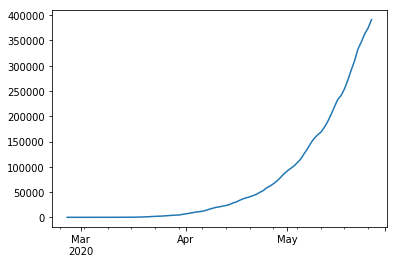

In [467]:
date_case_2['Cases'].plot()
plt.show()

In [489]:
def est_trend(data, n, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    plt.figure(1)
    plt.plot(data_est)
    plt.plot(movingAvg, color = 'red')
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    
    plt.figure(2)
    plt.plot(diff)
    plt.plot(movingAvg, color = 'red', label = 'MovingAvg')
    plt.plot(movingStd, color = 'black', label = 'MovingStd')
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.ar_model import AR
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = int(np.floor(0.2 * len(X)))
    train = X[1: len(X) - n]
    test = X
    
    ##fit and train model using split data
    model = AR(train)
    model_fitted = model.fit()
    print('the lag value is: %s' % model_fitted.k_ar)
    lag = model_fitted.k_ar
    lag = lag + 1
    
    predict = model_fitted.predict(start = lag, end = len(test) , dynamic = False)

    ##plot predicted data vs. true/observed data
    plt.figure(3)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(predict, color = 'red')
    
    orig = np.exp(predict)
    plt.figure(4)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(orig, color = 'red')
    
    
    ## error analysis - try a few different methods
    
    #r^2 error analysis - not metric to show if model is a good future predictor, but shows if model is good fit to 
    #observed data
    r2_err = r2_score(data_est.tail(len(X) - lag +1), predict)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(data_est.tail(len(X) - lag + 1), predict)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(predict, data_est.tail(len(X) - lag + 1))
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)
    
    new_pred = [np.nan] * (lag - 1)
    new_pred = new_pred + list(predict)
    
    new_df['Y_predicted'] = new_pred
    new_df['Y_original'] = list(data_est['Cases'])
    
    return new_df

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.281522
p-value                         0.015725
#Lags Used                      8.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64
the lag value is: 11
R^2 error: 0.9851475570184812
Mean Absolute Error: 0.25917907998442924
Mean squared error: 0.10136153188812291
Root mean squared error: 0.3183732587516152


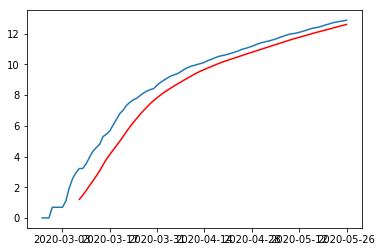

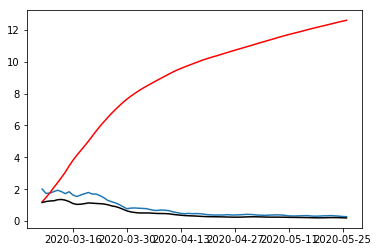

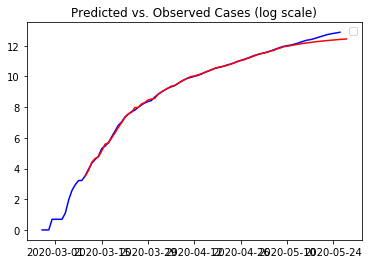

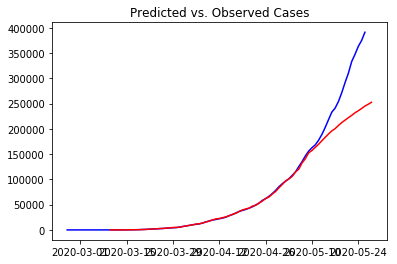

In [490]:
comb = est_trend(date_case_2, 40, compiled)

In [488]:
comb['Error'] = np.nan
n = 0
while (n < len(comb['Y_predicted'])):
    error = (comb['Y_predicted'][n] - comb['Y_original'][n]) / comb['Y_original'][n]
    comb['Error'][n] = error
    n += 1
print("Average Percent Error: %s" % np.mean(comb['Error']))
print(np.sum(comb['Error'][18:]) / (79-18))

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Average Percent Error: 0.03520225902823646
0.02902969900264984


In [246]:
comb.to_csv('compiled_brazil.csv')

In [43]:
brazil_new_df = pd.read_csv('brazil_covid19_new.csv')

In [55]:
brazil_new_df['date'] = pd.to_datetime(brazil_new_df['date'])

In [69]:
new_dates = []
new_cases = []
date = brazil_new_df['date'][1680]
while (date <= datetime.strptime('2020-05-26', '%Y-%m-%d')):
    total = 0
    for x in brazil_new_df[brazil_new_df['date'] == date]['cases']:
        total = total + x
    new_cases.append(total)
    new_dates.append(date)
    date = date + timedelta(1)
new_case= list(zip(new_dates, new_cases))
new_case_df = pd.DataFrame(new_case, columns = ['New Dates', 'New Cases'])

In [794]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import r2_score

def orig_pred(data, new_data):

    Y = data
    n = int(np.floor(0.05 * len(Y)))
    train = Y[: len(Y) - n]
    test = Y

    model = AR(train)
    model_fitted = model.fit()
    print('the lag value is: %s' % model_fitted.k_ar)
    lag = model_fitted.k_ar

    predict = model_fitted.predict(start = lag * 2, end = len(test) - 1 + 12, dynamic = False)


    plt.plot(data)
    plt.title("Original Data Prediction (No Transformation)")
    plt.plot(predict, color = 'red')
    plt.plot(new_data['New Dates'], new_data['New Cases'], color = 'orange')

the lag value is: 12


/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


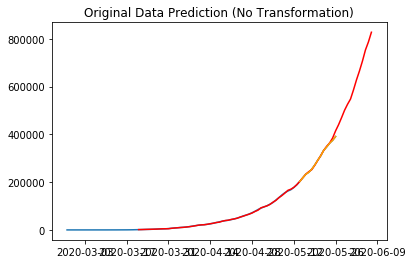

In [795]:
orig_pred(date_case_2, new_case_df)

## Moving Average Prediction

In [417]:
from numpy import mean
log_data = np.log(date_cases_values)
window = 2

In [449]:
log_past = [log_data[i] for i in range(window)]
log_test = ([log_data[i] for i in range(window, len(log_data))])

log_predictions = list()
dates = final_keys[2:]

In [419]:
for t in range(len(log_test)):
    length = len(log_past)
    yhat = mean([log_past[i] for i in range(length-window, length)])
    obs = log_test[t]
    log_predictions.append(yhat)
    log_past.append(obs)

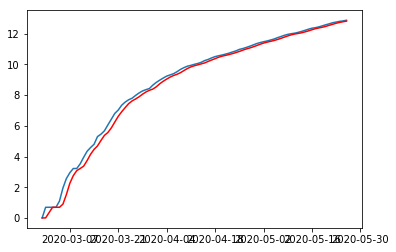

In [448]:
plt.plot(dates, log_test)
plt.plot(dates, log_predictions, color = 'red')
plt.show()

In [438]:
test = np.exp(log_test)
predictions = np.exp(log_predictions)
predictions = np.delete(predictions, 0)

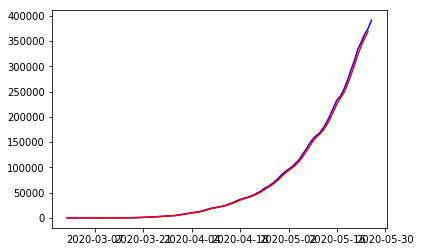

In [452]:
plt.plot(dates, test, color = 'blue')
plt.plot(dates[:-1], predictions, color ='red')
plt.show()

In [453]:
errors = list()
for i in range(len(predictions)):
    err = abs(test[i] - predictions[i])/test[i]
    errors.append(err)
print(mean(errors))

0.06769633642837977


## ARIMA Modeling

In [498]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [804]:
def arima_est(data, n, new_df):
    ##Estimating Trend
    data_est = np.log(data)

    
    ##calculating moving averages

    movingAvg = data_est.rolling(window=12).mean()
    movingStd = data_est.rolling(window = 12).std()
    
    #fig, axs = plt.subplots(3)
    
    ##diff between moving averages and actual cases
    diff = data_est - movingAvg
    ##remove null values
    diff.dropna(inplace = True)
    

    ##reperform Dickey-Fuller Test on transformed data to check stationarity
    print("Results of Dickey-Fuller Test")
    test = adfuller(data_est['Cases'], autolag = "AIC")

    output = pd.Series(test[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for k,v in test[4].items():
        output['Critical Value (%s)'%k] = v
    
    print(output)
    
    ##calculate weighted average
    weight_avg = data_est.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
    
    ##exponentiate to reverse log transformation (e^x)
    #data_est = np.exp(data_est)
    
    ##prediction 
    
   
    from statsmodels.tsa.arima_model import ARIMA
    from sklearn.metrics import r2_score

    ##split data into train and test
    X = (data_est).dropna()
    n = int(np.floor(0.09 * len(X)))
    train = X[0: len(X) - n]
    test = X
    
    ##fit and train model using split data
    lag = 11
    model2 = ARIMA(train, order = (1,1,2))
    model2_fitted = model2.fit(disp = False)
    
    yhat = model2_fitted.predict(lag, len(data_est) - 1, typ = 'levels')

    ##plot predicted data vs. true/observed data
    plt.figure(1)
    plt.title("Predicted vs. Observed Cases (log scale)")
    plt.legend()
    plt.plot(data_est, color = 'blue')
    plt.plot(yhat, color = 'red')
    
    yhat_case = np.exp(yhat)
    plt.figure(2)
    plt.title("Predicted vs. Observed Cases")
    plt.plot(data, color = 'blue')
    plt.plot(yhat_case, color = 'red')
    
    
    ## error analysis - try a few different methods
    
    #r^2 error analysis - not metric to show if model is a good future predictor, but shows if model is good fit to 
    #observed data
    r2_err = r2_score(data_est.tail(len(X) - lag), yhat)
    print('R^2 error: %s' % r2_err)
    
    #mean absolute error - measuring prediction errors because prediction in same unit as original (avg forecast error)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(data_est.tail(len(X) - lag), yhat)
    print('Mean Absolute Error: %s' % mae)
    
    #root mean squared error - sqrt average of square of forecase error (mse): basically same as mse but when dealing
    #with prediction in same unit as original - how concentrated is data around line of best fit
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(yhat, data_est.tail(len(X) - lag))
    print('Mean squared error: %s' % mse)
    
    rmse = np.sqrt(mse)
    print('Root mean squared error: %s' % rmse)
    
    new_pred = [np.nan] * (lag )
    new_pred = new_pred + list(yhat_case)
    
    new_df['Y_predicted'] = new_pred
    new_df['Y_original'] = list(data['Cases'])
    
    return new_df

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
No handles with labels found to put in legend.


Results of Dickey-Fuller Test
Test Statistic                 -3.281522
p-value                         0.015725
#Lags Used                      8.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64
R^2 error: 0.999001538408765
Mean Absolute Error: 0.05593385542752534
Mean squared error: 0.006814070691600208
Root mean squared error: 0.08254738452307382


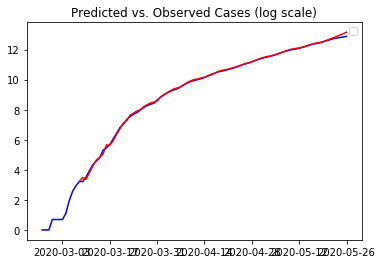

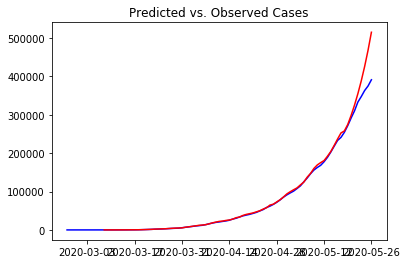

In [805]:
compiled_pred = arima_est(date_case_2,40, compiled)

In [808]:
compiled_pred['Error'] = np.nan
n = 0
while (n < len(compiled_pred['Y_predicted'])):
    error = abs(compiled_pred['Y_predicted'][n] - compiled_pred['Y_original'][n]) / compiled_pred['Y_original'][n]
    compiled_pred['Error'][n] = error
    n += 1
print("Average Percent Error: %s" % np.mean(compiled_pred['Error']))

/Users/anyaaggarwal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Average Percent Error: 0.05762628389557071
